In [1]:
#Import Packages
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import rioxarray as rx
import rasterio as rs

In [2]:
# geodataframe
balt_bg = gpd.read_file("model_inputs/bg_baltimore.csv", 
                        GEOM_POSSIBLE_NAMES="geometry",
                        KEEP_GEOM_COLUMNS="NO")

balt_bg = balt_bg.set_crs('epsg:3857')
#To Albers contiguous equal area
bg_visual = balt_bg.to_crs("ESRI:102003")
bg_area = balt_bg["geometry"].area
bg_visual["area"] = bg_area


In [3]:
bg_visual["area"]

0        32267.327390
1         1257.672927
2        18889.108418
3         2095.005037
4        13895.857566
            ...      
1215    705247.261227
1216    446716.405821
1217    722080.135296
1218    272431.075680
1219    102475.507088
Name: area, Length: 1220, dtype: float64

<Axes: >

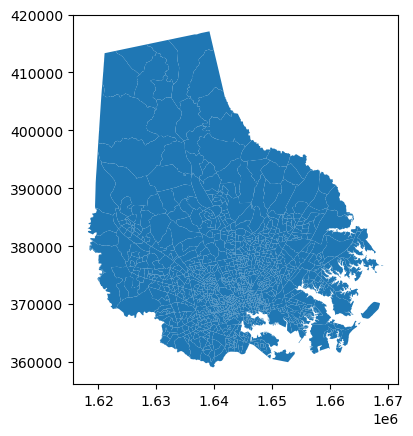

In [4]:
#visualize geodataframe
bg_visual.plot()

In [4]:
#open tif file. file in 'epsg:4269'
raster_base = rx.open_rasterio("flood_inputs/FastFlood/Base/Surge-Baltimore2-10m_Base_275.tif").rio.reproject("ESRI:102003")
raster_levee = rx.open_rasterio("flood_inputs/FastFlood/Levee/Surge-Baltimore2-10m_All_275.tif").rio.reproject("ESRI:102003")
#-76.75, 39.15, -76.5, 39.38
#rio.clip_box(-76.7, 39.25, -76.55, 39.35)
rasters = [raster_base, raster_levee]
#raster.rio.crs
#combine rasters
#ds_grid = [[raster_base, raster_levee], [raster_base, raster_levee]]
#xr.combine_nested(ds_grid,concat_dim=["x","y"])
#raster_base = raster_base


In [88]:
np.unique(raster_base[0].values.flatten())

array([0.0000000e+00, 1.3089180e-04, 1.4114380e-04, ..., 7.1626883e+00,
       7.2284360e+00, 7.3495131e+00], dtype=float32)

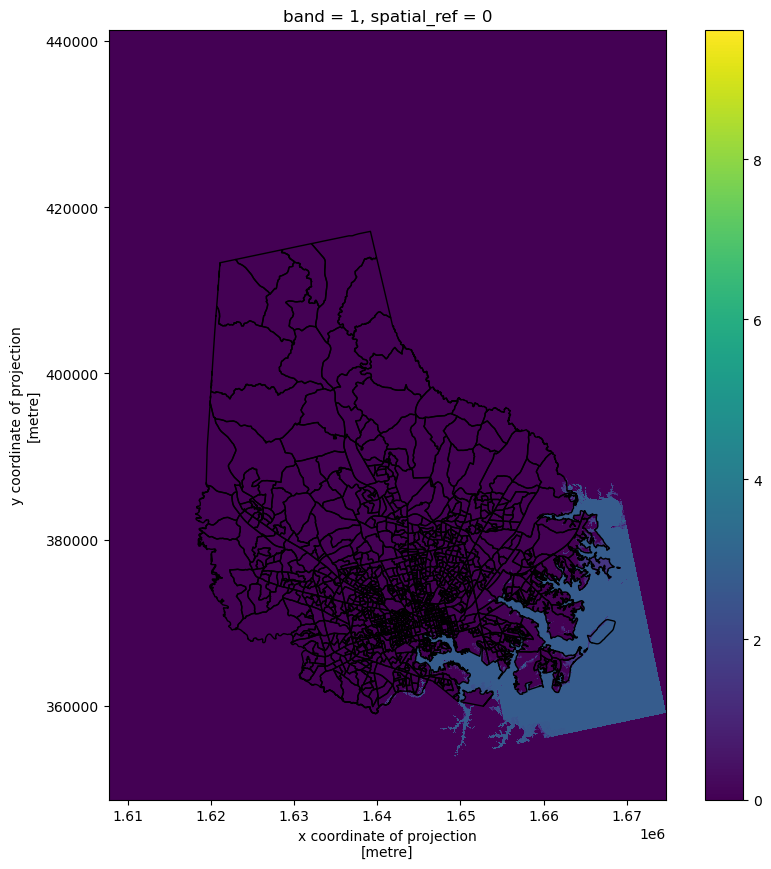

In [7]:
fig, ax = plt.subplots(1, figsize=(10, 10))

xlim = ([1.63, 1.66])
ylim = ([360000, 380000])

ax.set_xlim(xlim)
ax.set_ylim(ylim)


raster_base.plot(ax = ax)
bg_visual.plot(ax = ax, facecolor = "none")
plt.show()

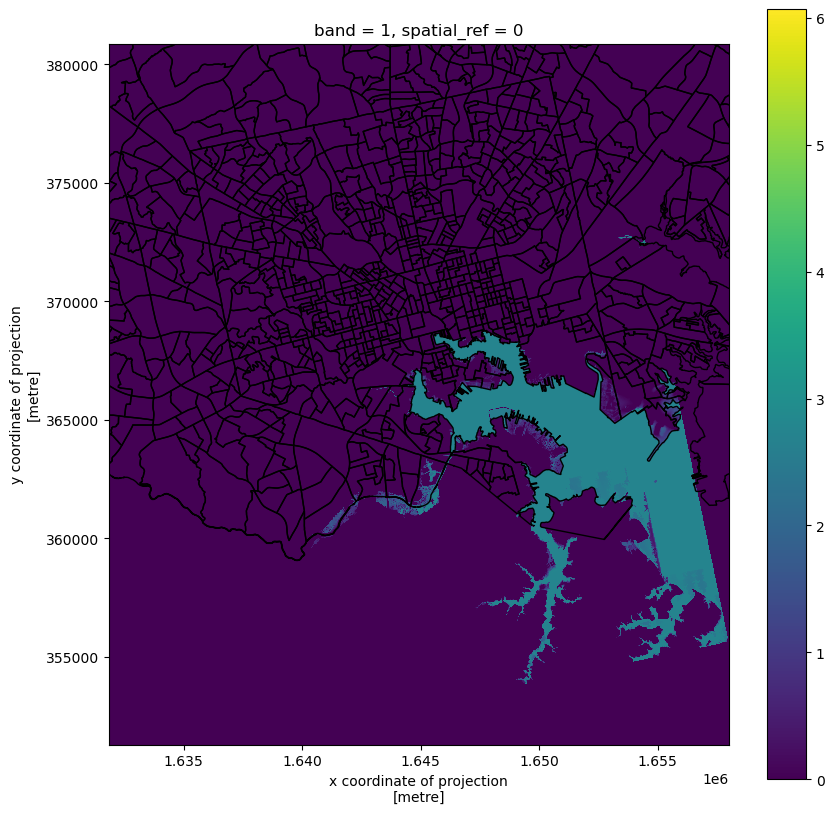

In [73]:

fig, ax = plt.subplots(1, figsize=(10, 10))

xlim = ([-76.75,  -76.5])
ylim = ([39.2,  39.38])

ax.set_xlim(xlim)
ax.set_ylim(ylim)

raster_levee.plot(ax=ax)
bg_visual.plot(ax=ax, facecolor = "none")
plt.show()

In [127]:
ras = rs.open(r"flood_inputs/FastFlood/Base/Surge-Baltimore2-10m_Base_175.tif")
a = ras.transform
a[0] * 111139

10.290648193426922

In [5]:
def get_res(filename):
    image = rx.open_rasterio(filename).rio.reproject("ESRI:102003")
    #find pixel resolution of image and save x,y dimensions
    pixelSizeX, pixelSizeY = image.rio.resolution()
    #Multiply pixel dimensions to get area of one pixel
    area = abs(pixelSizeX * pixelSizeY)
    return area

In [6]:
buff = get_res("flood_inputs/FastFlood/Base/Surge-Baltimore2-10m_Base_175.tif")
buff

89.93078171030803

In [7]:

band = rasters[0][0]
x, y, extent = band.x.values, band.y.values, band.values
x, y = np.meshgrid(x, y)
x, y, extent = x.flatten(), y.flatten(), extent.flatten()

#Convert to point geometries 
centroids = gpd.GeoDataFrame(geometry=gpd.GeoSeries.from_xy(x, y, crs=band.rio.crs))
#create new geoseries with pixel geometries
#pixels = centroids.buffer(buff, cap_style=3)
#polygons = gpd.GeoDataFrame(geometry=pixels, crs=band.rio.crs)
extent[extent > 0] = 1
centroids['base'] = extent


#band_list = [[]for i in range(len(rasters[1:]))]
band_dict = {}
for ras in rasters[1:]:
    #get first band of raster
    band = ras[0]
    extent = band.values.flatten()
    extent[extent > 0] = 1
    ##add to list
    #need to figure out better naming sequence
    band_dict['levee'] = extent

band_df = pd.DataFrame.from_dict(band_dict)
centroids = pd.concat([centroids, band_df], axis = 1)

    
    


In [8]:
bg_visual

,field_1,fid_1,GISJOIN,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,...,rel_prox_cbd,rel_flood_risk,prox_cbd_norm,flood_risk_norm,housing_budget_perc,new_price,x,y,geometry,area
0,0,1.0,G24000307301003,24,003,730100,3,240037301003,Block Group 3,G5030,...,34891.82763,1.7284635534498893,0.7243393674712884,0.9999846881494844,0.40556080331841143,46000.0,-8520629.499269817,4750656.273308398,"POLYGON ((1653922.227 361402.870, 1653007.940 ...",32267.327390
1,1,2.0,G24000307501012,24,003,750101,2,240037501012,Block Group 2,G5030,...,41419.013269,1.7284900198306907,0.8598409401391497,1.0,0.31237880496054116,54000.0,-8528157.396683514,4755054.4880457595,"MULTIPOLYGON (((1647443.227 362369.748, 164744...",1257.672927
2,2,3.0,G24000307501021,24,003,750102,1,240037501021,Block Group 1,G5030,...,41674.114506,1.7112942675125786,0.8651367323403827,0.9900515755828336,0.2884848484848485,63000.0,-8529373.867370525,4755380.562356441,"MULTIPOLYGON (((1646426.207 363056.316, 164637...",18889.108418
3,3,4.0,G24000307502012,24,003,750201,2,240037502012,Block Group 2,G5030,...,39934.068866,1.7279815049292162,0.8290141316095144,0.9997058039701471,0.4111851454195219,78000.0,-8531450.941559572,4753882.396408373,"MULTIPOLYGON (((1645038.186 361355.094, 164503...",2095.005037
4,4,5.0,G24000307503001,24,003,750300,1,240037503001,Block Group 1,G5030,...,40171.03544,1.7243054823632677,0.8339334559895138,0.9975790791850607,0.2204724409448819,78000.0,-8532547.673794687,4754495.04852733,"MULTIPOLYGON (((1644425.151 361474.093, 164441...",13895.857566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1215,1215,1216.0,G24051002804042,24,510,280404,2,245102804042,Block Group 2,G5030,...,41307.884346,1.7284900198306907,0.8575339513896014,1.0,,45000.0,-8537465.9547501,4763391.812551977,"POLYGON ((1639027.946 367529.864, 1638993.846 ...",705247.261227
1216,1216,1217.0,G24051002805001,24,510,280500,1,245102805001,Block Group 1,G5030,...,46646.306109000005,1.7284900198306907,0.9683572961599305,1.0,,23000.0,-8526760.10738695,4764129.857579765,"POLYGON ((1646707.424 370279.910, 1646735.621 ...",446716.405821
1217,1217,1218.0,G24051002805002,24,510,280500,2,245102805002,Block Group 2,G5030,...,47408.6371701,1.5256893411816574,0.984182961827444,0.8826717676571265,,23000.0,-8527839.375244973,4763938.606062005,"POLYGON ((1646070.846 369737.805, 1646096.476 ...",722080.135296
1218,1218,1219.0,G24051002805003,24,510,280500,3,245102805003,Block Group 3,G5030,...,46994.102864,1.7284900198306907,0.9755774075337658,1.0,,23000.0,-8527358.147564553,4764208.659992062,"POLYGON ((1646331.925 369806.614, 1646280.079 ...",272431.075680


In [9]:
#join centroid geometries with block group geometries
bg_flood_area = gpd.sjoin(bg_visual,centroids, how = 'left')



In [51]:
#determine whether max flood depth occurrence within each block group
bg_flood_max = bg_flood_area[["GISJOIN","base","levee"]].groupby('GISJOIN', as_index = False).agg(lambda x: x.ne(0).sum())
#Rejoin block area and fid_1 columns
balt_flood = bg_visual[["GISJOIN","fid_1", "area"]].merge(bg_flood_max, on='GISJOIN')
#bg_flood_max[["base", "levee"]] = bg_flood_max[["base", "levee"]] * buff
balt_flood.loc[:,~balt_flood.columns.isin(['GISJOIN', 'fid_1', 'area'])] = (balt_flood.loc[:,~balt_flood.columns.isin(['GISJOIN', 'fid_1', 'area'])] * buff).div(balt_flood['area'], axis=0)

#Divide
#balt_flood[["base", "levee"]] = balt_flood[["base", "levee"]].div(balt_flood['area'], axis=0)

/var/folders/c5/dps3lj6n2sz8zkk_381lj9b1hnpv4f/T/ipykernel_10318/3686469409.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.01672232 0.         0.59512326 ... 0.         0.         0.        ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  balt_flood.loc[:,~balt_flood.columns.isin(['GISJOIN', 'fid_1', 'area'])] = (balt_flood.loc[:,~balt_flood.columns.isin(['GISJOIN', 'fid_1', 'area'])] * buff).div(balt_flood['area'], axis=0)
/var/folders/c5/dps3lj6n2sz8zkk_381lj9b1hnpv4f/T/ipykernel_10318/3686469409.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.01672232 0.         0.59512326 ... 0.         0.         0.        ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  balt_flood.loc[:,~balt_flood.columns.isin(['GISJOIN', 'fid_1', 'area'])] = (balt_flood.

In [52]:
balt_flood

,GISJOIN,fid_1,area,base,levee
0,G24000307301003,1.0,32267.327390,0.016722,0.016722
1,G24000307501012,2.0,1257.672927,0.000000,0.000000
2,G24000307501021,3.0,18889.108418,0.595123,0.595123
3,G24000307502012,4.0,2095.005037,0.600968,0.600968
4,G24000307503001,5.0,13895.857566,0.575987,0.575987
...,...,...,...,...,...
1215,G24051002804042,1216.0,705247.261227,0.000000,0.000000
1216,G24051002805001,1217.0,446716.405821,0.000000,0.000000
1217,G24051002805002,1218.0,722080.135296,0.000000,0.000000
1218,G24051002805003,1219.0,272431.075680,0.000000,0.000000


In [30]:
#Rejoin Geometries for Plotting Purposes
balt_flood_area = bg_visual[["GISJOIN","geometry"]].merge(balt_flood, on='GISJOIN')
f_area_gdf = gpd.GeoDataFrame(balt_flood_area, geometry = balt_flood_area.geometry, crs = bg_visual.crs)

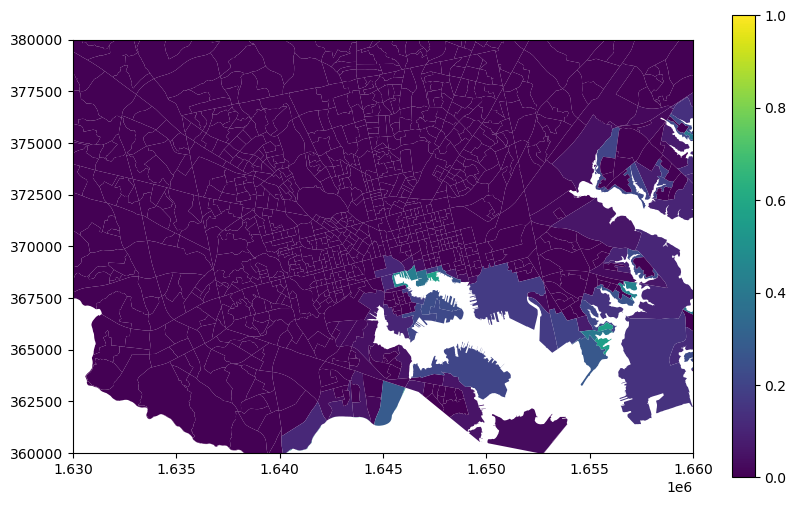

In [34]:
fig, ax = plt.subplots(figsize = (10,6))

xlim = ([1.63e6, 1.66e6])
ylim = ([360000, 380000])

ax.set_xlim(xlim)
ax.set_ylim(ylim)

balt_flood_area.plot(column = 'base',legend=True, vmin = 0, vmax = 1, ax = ax)
plt.show()

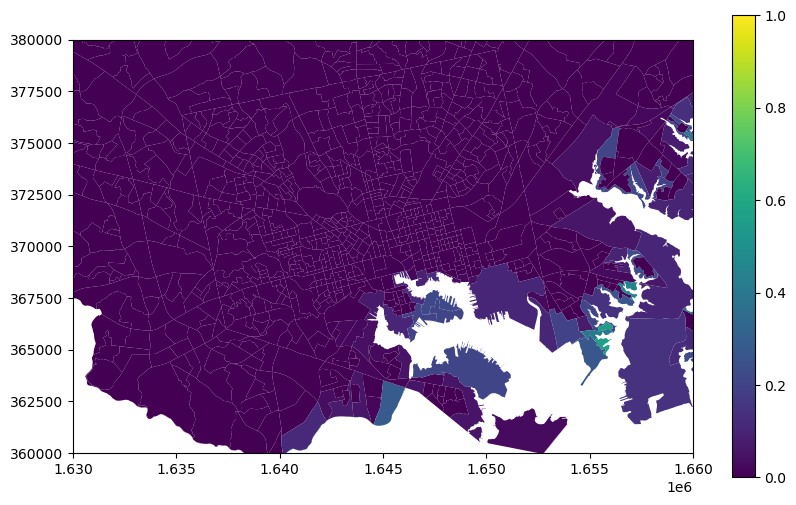

In [38]:
fig, ax = plt.subplots(figsize = (10,6))

xlim = ([1.63e6, 1.66e6])
ylim = ([360000, 380000])

ax.set_xlim(xlim)
ax.set_ylim(ylim)

balt_flood_area.plot(column = 'levee',legend=True, vmin = 0, vmax = 1, ax = ax)
plt.show()

In [7]:
#load surge csvs
balt_base = pd.read_csv('model_inputs/surge_baltimore_base.csv')
balt_levee = pd.read_csv('model_inputs/surge_baltimore_levee.csv')

#Rejoin block group geometries
balt_base = bg_visual[["GISJOIN","geometry"]].merge(balt_base, on='GISJOIN')
base_gdf = gpd.GeoDataFrame(balt_base, geometry = balt_base.geometry, crs = bg_visual.crs)
balt_levee = bg_visual[["GISJOIN","geometry"]].merge(balt_levee, on='GISJOIN')
levee_gdf = gpd.GeoDataFrame(balt_levee, geometry = balt_levee.geometry, crs = bg_visual.crs)

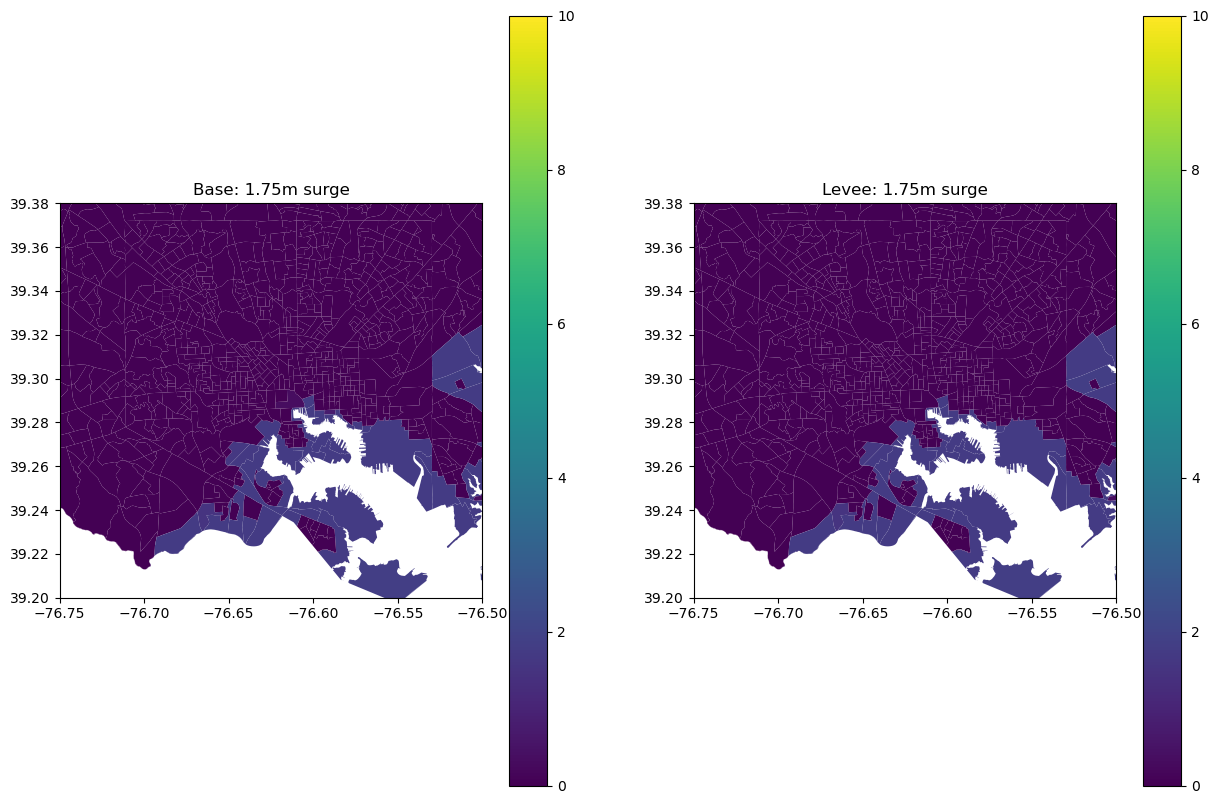

In [15]:
fig, axs = plt.subplots(1,2,figsize = (15,10))

xlim = ([-76.75,  -76.5])
ylim = ([39.2,  39.38])

axs[0].set_xlim(xlim)
axs[0].set_ylim(ylim)

axs[1].set_xlim(xlim)
axs[1].set_ylim(ylim)



base_gdf.plot(column = '1.75',legend=True, vmin = 0, vmax = 10, ax = axs[0])
levee_gdf.plot(column = '1.75',legend=True, vmin = 0, vmax = 10, ax = axs[1])


axs[0].set_title('Base: 1.75m surge')
axs[1].set_title('Levee: 1.75m surge')

plt.show()

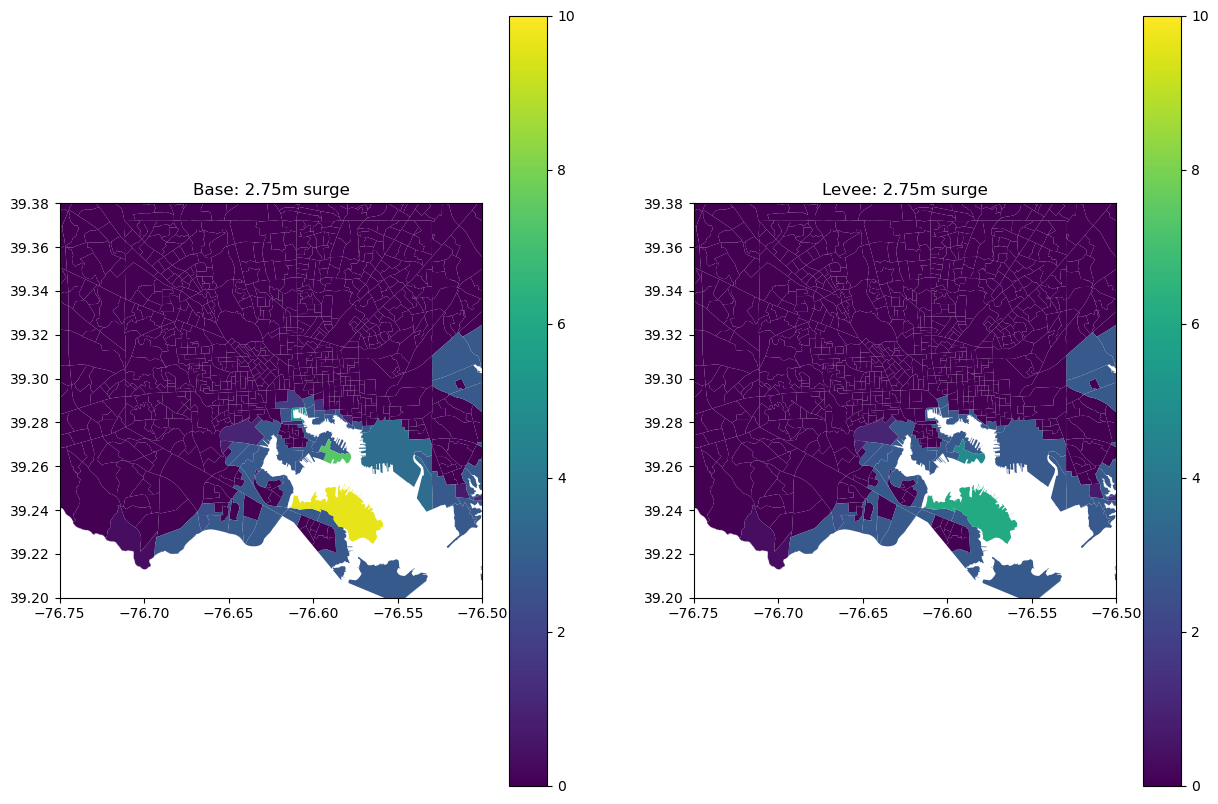

In [19]:
fig, axs = plt.subplots(1,2,figsize = (15,10))

xlim = ([-76.75,  -76.5])
ylim = ([39.2,  39.38])

axs[0].set_xlim(xlim)
axs[0].set_ylim(ylim)

axs[1].set_xlim(xlim)
axs[1].set_ylim(ylim)



base_gdf.plot(column = '2.75',legend=True, vmin = 0, vmax = 10, ax = axs[0])
levee_gdf.plot(column = '2.75',legend=True, vmin = 0, vmax = 10, ax = axs[1])


axs[0].set_title('Base: 2.75m surge')
axs[1].set_title('Levee: 2.75m surge')

plt.show()

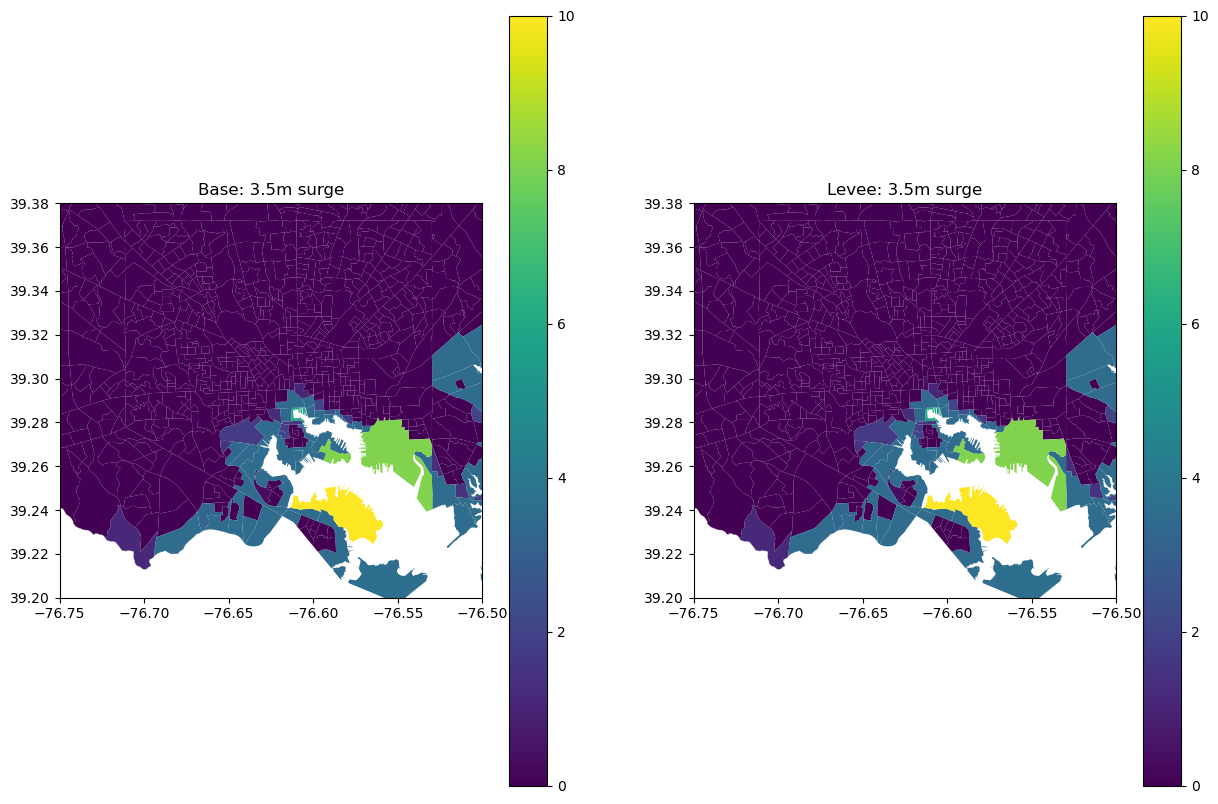

In [32]:
fig, axs = plt.subplots(1,2,figsize = (15,10))

xlim = ([-76.75,  -76.5])
ylim = ([39.2,  39.38])

axs[0].set_xlim(xlim)
axs[0].set_ylim(ylim)

axs[1].set_xlim(xlim)
axs[1].set_ylim(ylim)



base_gdf.plot(column = '3.5',legend=True, vmin = 0, vmax = 10, ax = axs[0])
levee_gdf.plot(column = '3.5',legend=True, vmin = 0, vmax = 10, ax = axs[1])


axs[0].set_title('Base: 3.5m surge')
axs[1].set_title('Levee: 3.5m surge')

plt.show()

In [53]:
#load surge area csvs
balt_base = pd.read_csv('model_inputs/surge_area_baltimore_base.csv')
balt_levee = pd.read_csv('model_inputs/surge_area_baltimore_levee.csv')

#Rejoin block group geometries
balt_base = bg_visual[["GISJOIN","geometry"]].merge(balt_base, on='GISJOIN')
base_gdf = gpd.GeoDataFrame(balt_base, geometry = balt_base.geometry, crs = bg_visual.crs)
balt_levee = bg_visual[["GISJOIN","geometry"]].merge(balt_levee, on='GISJOIN')
levee_gdf = gpd.GeoDataFrame(balt_levee, geometry = balt_levee.geometry, crs = bg_visual.crs)

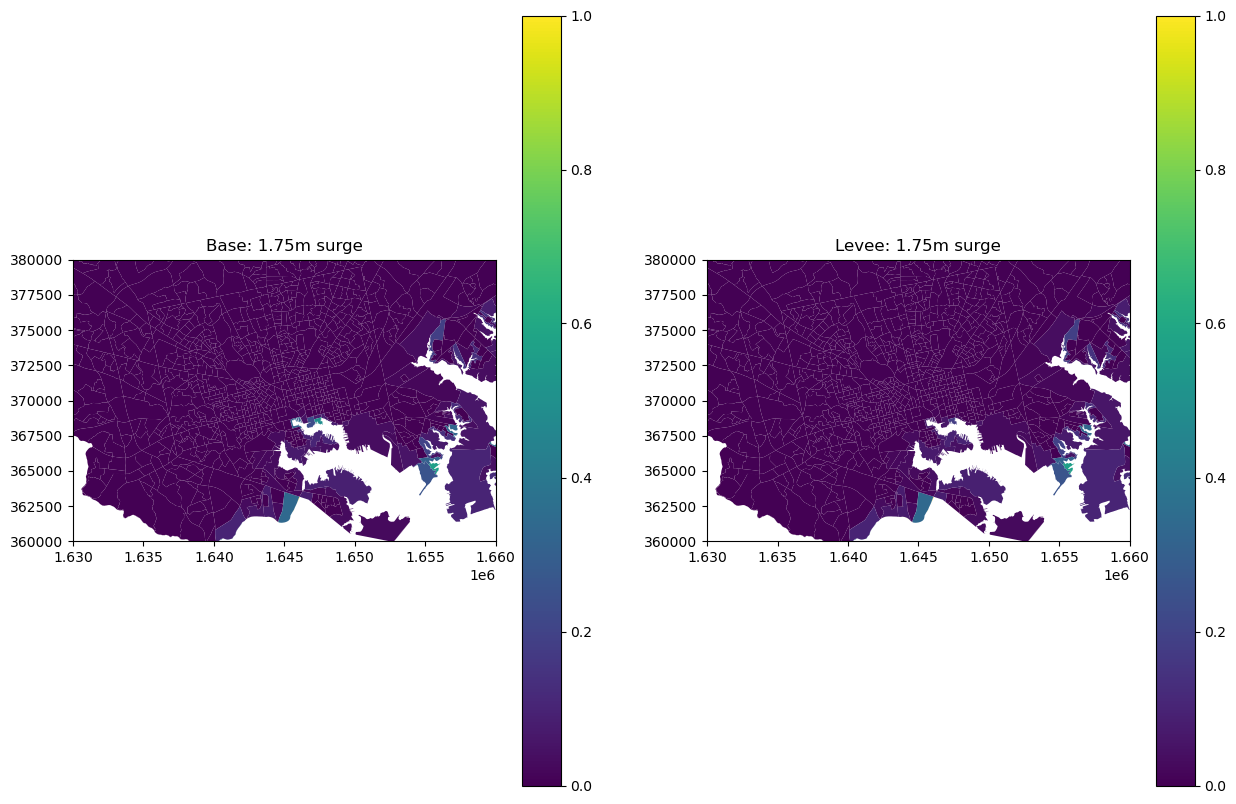

In [55]:
fig, axs = plt.subplots(1,2,figsize = (15,10))

xlim = ([1.63e6, 1.66e6])
ylim = ([360000, 380000])

axs[0].set_xlim(xlim)
axs[0].set_ylim(ylim)

axs[1].set_xlim(xlim)
axs[1].set_ylim(ylim)



base_gdf.plot(column = '1.75',legend=True, vmin = 0, vmax = 1, ax = axs[0])
levee_gdf.plot(column = '1.75',legend=True, vmin = 0, vmax = 1, ax = axs[1])


axs[0].set_title('Base: 1.75m surge')
axs[1].set_title('Levee: 1.75m surge')

plt.show()

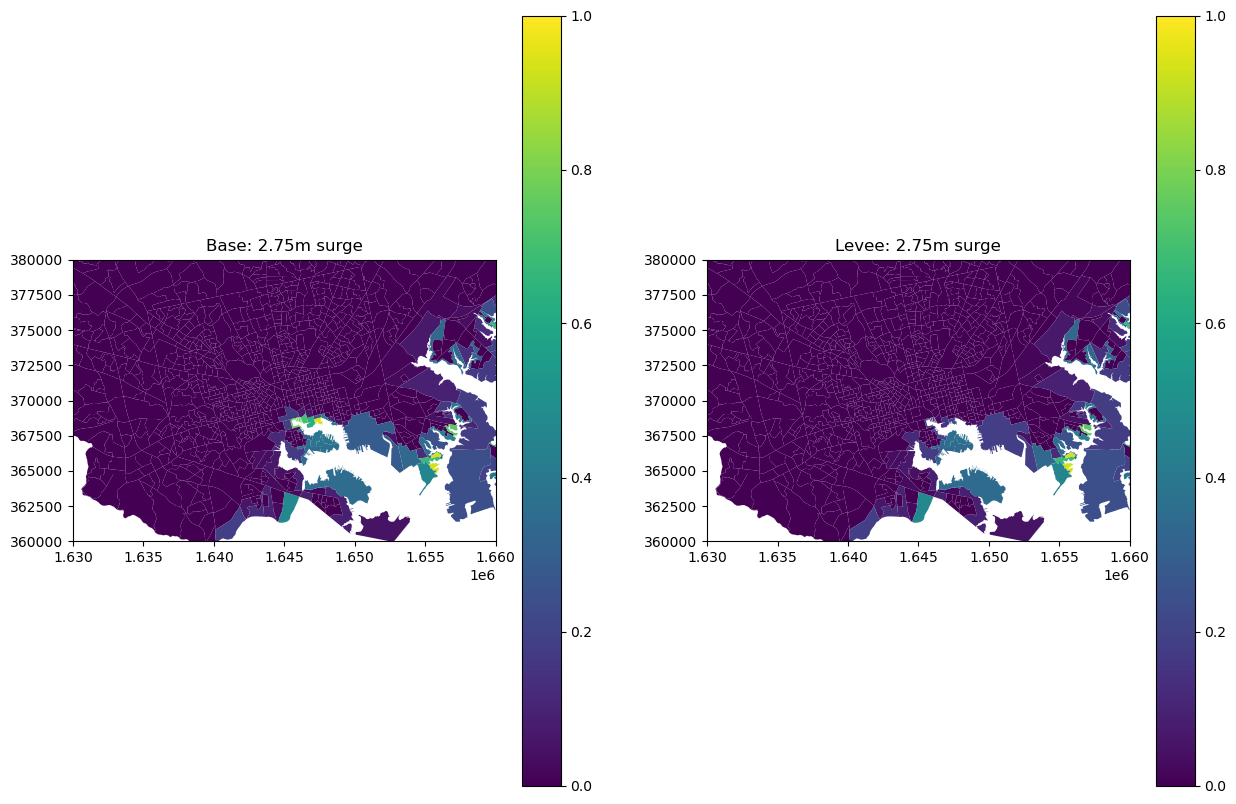

In [56]:
fig, axs = plt.subplots(1,2,figsize = (15,10))

xlim = ([1.63e6, 1.66e6])
ylim = ([360000, 380000])

axs[0].set_xlim(xlim)
axs[0].set_ylim(ylim)

axs[1].set_xlim(xlim)
axs[1].set_ylim(ylim)



base_gdf.plot(column = '2.75',legend=True, vmin = 0, vmax = 1, ax = axs[0])
levee_gdf.plot(column = '2.75',legend=True, vmin = 0, vmax = 1, ax = axs[1])


axs[0].set_title('Base: 2.75m surge')
axs[1].set_title('Levee: 2.75m surge')

plt.show()

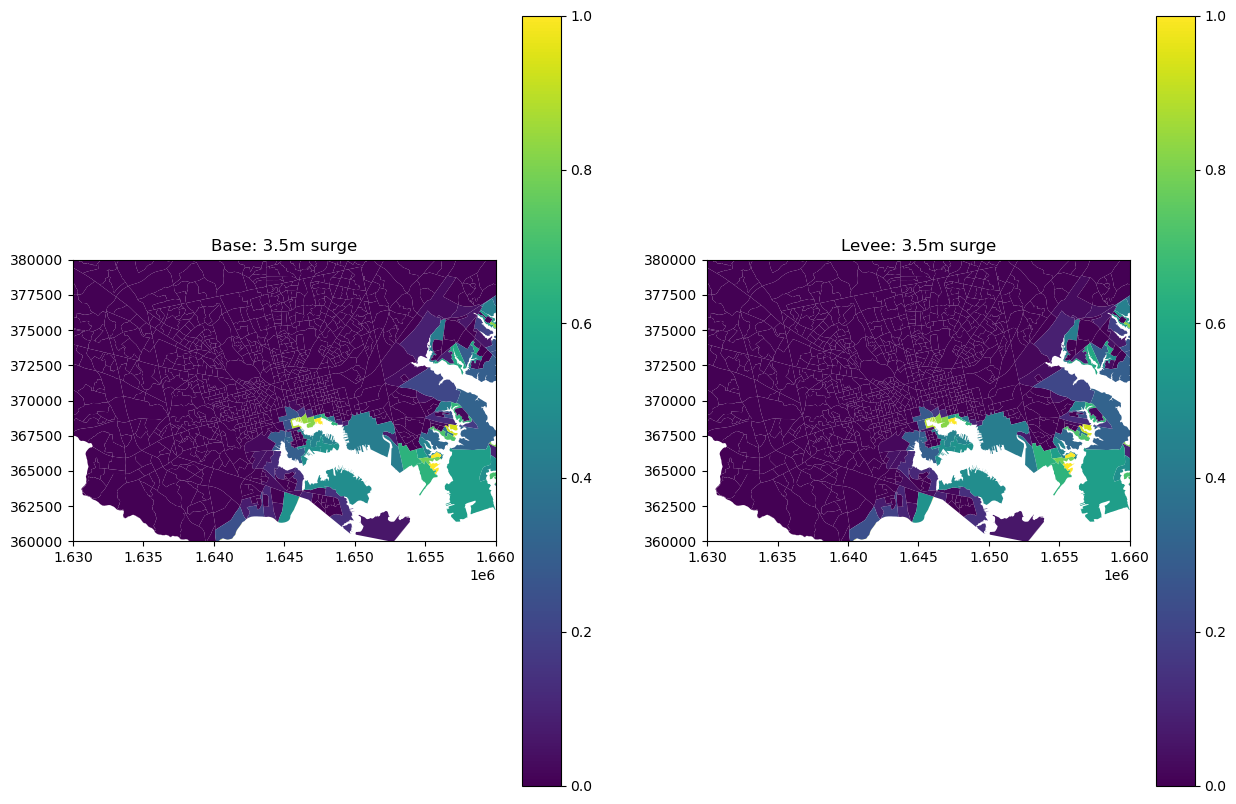

In [57]:
fig, axs = plt.subplots(1,2,figsize = (15,10))

xlim = ([1.63e6, 1.66e6])
ylim = ([360000, 380000])

axs[0].set_xlim(xlim)
axs[0].set_ylim(ylim)

axs[1].set_xlim(xlim)
axs[1].set_ylim(ylim)



base_gdf.plot(column = '3.5',legend=True, vmin = 0, vmax = 1, ax = axs[0])
levee_gdf.plot(column = '3.5',legend=True, vmin = 0, vmax = 1, ax = axs[1])


axs[0].set_title('Base: 3.5m surge')
axs[1].set_title('Levee: 3.5m surge')

plt.show()